<font size="16"><center>The Traveling TSP Salesman Problem</font></center><br>
<i><center>Finding solutions using genetic algorithms</i><br>
    <center>
        <b>Presented by:</b><br>
Moustafa Elsisy<br>
Rob Bishop<br>
Caleb Graves<br>
Vineel Nagisetty<br>
    </center>

## Setup
We begin by importing all our required modules. In addition to modules created by us, we are using numpy and numba for faster calculations, and matplotlib for animations
***

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
%matplotlib inline
from src.tsp_instance import TSP
from src.initialization import Initialization
from src.parent_selection import Parent_Selection
from src.recombination import Recombination
from src.mutation import Mutation
from src.evaluation import Evaluation
from src.survivor_selection import Survivor_Selection
from src.termination import Termination
from src.animation import Animation
from src.utils import *
from src.utils import debug_print as print
from src.file_utils import parse_file as parse
from src.preprocessing import precalculate_distances

## Loading and precalculating data
Our evaluation module automatically precalulates distances between cities, but we will invoke the function here manually to demonstrate the speed and memory usage
***

In [2]:
x_large_data  = "./data/TSP_Italy_16862.txt"
big_data      = "./data/TSP_Canada_4663.txt"
middle_data   = "./data/TSP_Uruguay_734.txt"
small_data    = "./data/TSP_WesternSahara_29.txt"

In [3]:
%time data = parse(middle_data)

CPU times: user 2.08 ms, sys: 984 µs, total: 3.07 ms
Wall time: 2.15 ms


We can see that parsing the file is a fast process, but how about precalculating the entire distance array?

In [4]:
%time dist_cache = precalculate_distances(data)
print("Size of the array in memory: {:.2f} Megabytes".format(dist_cache.nbytes/1048576))

CPU times: user 34.1 ms, sys: 4.71 ms, total: 38.8 ms
Wall time: 41.6 ms
Size of the array in memory: 4.11 Megabytes


## Setting up the test environment
By having individual modules for each step of the genetic algorithm process, we can rapidly switch between them and evaluate their relative speed and effectiveness. We will be using the middle dataset for all of these tests.

We have created a TSP instance class to represent a single instance of the problem, this includes a reference to the dataset, population size, number of parents, mutation rate ect.
***

In [13]:
POP_SIZE          = 150
NUM_PARENTS       = 100
NUM_GENERATIONS   = 6000
TIME_LIMIT        = 10000
MUTATION_RATE     = .2
INIT_METHOD       = "random_permutations"
SELECT_METHOD     = "random"
CROSSOVER_METHOD  = "order_crossover"
MUTATION_METHOD   = "swap"
EVALUATION_METHOD = "cached_euclidean"
SURVIVOR_METHOD   = "random"
TERMINATOR_METHOD = "num_iterations"
DATA              = parse(middle_data)

Our test method creates a new instance and series of modules from the defined constants. Changing our parameters is now as simple as changing our constants and re-running our testing method.

Our tsp instance class keeps a history of certain parameters over the course of evoloution, and each module uses a timer method we have written so we can easily identify bottlenecks.

In [21]:
def test_tsp():
    # create all modules and problem instance
    tsp = TSP(
        graph           = DATA,
        population_size = POP_SIZE,
        num_parents     = NUM_PARENTS,
        mutation_rate   = MUTATION_RATE,
        num_generations = NUM_GENERATIONS)
    initializer         = Initialization(tsp, INIT_METHOD)
    parent_selector     = Parent_Selection(tsp, SELECT_METHOD)
    recombinator        = Recombination(tsp, CROSSOVER_METHOD)
    mutator             = Mutation(tsp, MUTATION_METHOD)
    evaluator           = Evaluation(tsp, EVALUATION_METHOD)
    survivor_selector   = Survivor_Selection(tsp, SURVIVOR_METHOD)
    terminator          = Termination(NUM_GENERATIONS, TIME_LIMIT, TERMINATOR_METHOD)
    # initialize population and perform initial evaluation
    clear_times()
    start_timer("setup")
    initializer.initialize()
    evaluator.evaluate()
    start_timer("setup")
    print("*" * 20)
    print("Initial Mean Fitness: {:.2f}\t Best Fitness:{:.2f}".format(tsp.fitness.mean(), tsp.fitness.max()))
    print("*" * 20)
    current_time = 0
    while terminator.method(tsp.current_generation, current_time):
    # select parents and spawn children
        parent_selector.select()
        recombinator.recombine()
        # mutate population and children
        mutator.mutate_population()
        mutator.mutate_children()
        # re-evaluate children and population
        evaluator.evaluate(use_mask=True)
        evaluator.evaluate_children()
        # select from parents and children to form new population
        survivor_selector.select()
        # add history and print debugs every 10%
        tsp.add_history("mean_fitness",tsp.fitness.mean())
        tsp.add_history("best_fitness",tsp.fitness.max())
        std = tsp.fitness.std()
        tsp.add_history("std_dev",std)
        tsp.current_generation +=1
        if not (tsp.current_generation % (tsp.num_generations // 10)):
            print("Generation {:<4} Mean Fitness: {:5.2f}\t Best Fitness:{:5.2f}\t Fitness STD DEV: {:.2f}".format(
                tsp.current_generation, tsp.fitness.mean(), tsp.fitness.max(), std))
        if not (tsp.current_generation % (tsp.num_generations // 200)):
            tsp.add_history("best_individual", tsp.population[np.argmax(tsp.fitness.max())])
            tsp.add_history("ani_fitness", tsp.fitness.max())
            tsp.add_history("ani_generation", tsp.current_generation)
            
    # print("Best Member of Population:\n", tsp.population[np.argmax(tsp.fitness)])
    print("Final Mean Fitness: {}\t Best Fitness:{}".format(tsp.fitness.mean(), tsp.fitness.max()))
    print("*" * 10 + "\nFunction Times (in ms):\n")
    time_sum = 0
    for k, v in get_times():
        print("{:16}\t{:.2f}".format(k, v * 1000))
        time_sum+=v
    print("-"*20)
    print("Total Time:\t{:.2f} seconds".format(time_sum))
    return tsp

A simple function to plot the history of a tsp object

In [7]:
from IPython.display import display, Markdown
def plot_tsp(tsp, scale=1, title=None):
    fig = plt.figure(figsize=(25*scale,25*scale))    
    plt.subplot(3, 3, 1)
    plt.title("Mean Fitness", size=20*scale)
    plt.plot(tsp.history["mean_fitness"])

    plt.subplot(3, 3, 2)
    plt.title("Best Fitness", size=20*scale)
    plt.plot(tsp.history["best_fitness"])

    plt.subplot(3, 3, 3)
    plt.title("Fitness Standard Deviation", size=20*scale)
    plt.plot(tsp.history["std_dev"])
    plt.subplots_adjust(wspace = .3)
    if title is not None:
        t = Markdown('<font style="font-size: 28px"><center>{}</font><br/>'.format(title))
        display(t)
    plt.show()

## Proof of concept
We will test the suite using entirely random selection methods

In [8]:
random_tsp = test_tsp()

Random permutations method selected for initialization
Random method selected for parent selection
Order crossover method selected for recombination
Swap method selected for mutation
Cached euclidean distance method selected for evaluation
Random method selected for survivor selection
Fixed number of iterations method selected for termination
********************
Initial Mean Fitness: -1638738.03	 Best Fitness:-1564537.73
********************
Generation 1000 Mean Fitness: -1616470.59	 Best Fitness:-1596348.14	 Fitness STD DEV: 10600.43
Generation 2000 Mean Fitness: -1660495.57	 Best Fitness:-1640284.76	 Fitness STD DEV: 12567.78
Generation 3000 Mean Fitness: -1630738.00	 Best Fitness:-1590989.17	 Fitness STD DEV: 15540.95
Generation 4000 Mean Fitness: -1617217.47	 Best Fitness:-1592586.07	 Fitness STD DEV: 11330.19
Generation 5000 Mean Fitness: -1644609.97	 Best Fitness:-1600514.24	 Fitness STD DEV: 15192.94
Generation 6000 Mean Fitness: -1659006.84	 Best Fitness:-1644576.64	 Fitness S

<font style="font-size: 28px"><center>Random Parent and Survivor Selection</font><br/>

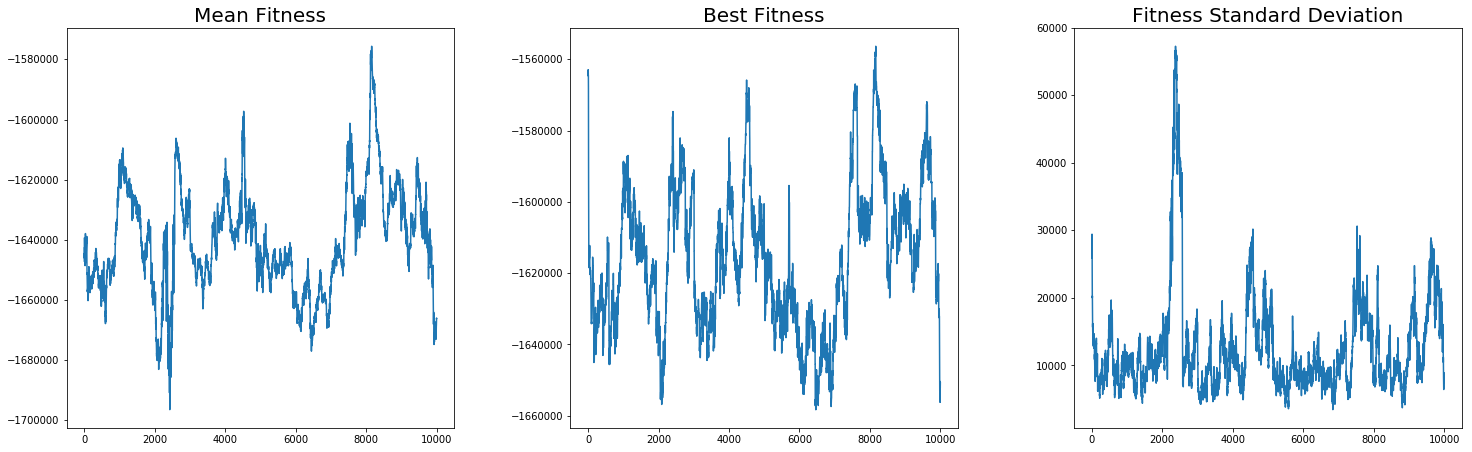

In [9]:
plot_tsp(random_tsp, title="Random Parent and Survivor Selection")

## Changing Parameters
To ensure the test suite is working, we'll change both parent selection methods to mu+lambda and will hopefully observe better results

Random permutations method selected for initialization
Roulette Wheel method selected for parent selection
Order crossover method selected for recombination
Cached euclidean distance method selected for evaluation
mu+lambda method selected for survivor selection
Fixed number of iterations method selected for termination
********************
Initial Mean Fitness: -1637079.29	 Best Fitness:-1579815.12
********************
Generation 600  Mean Fitness: -675074.07	 Best Fitness:-669031.03	 Fitness STD DEV: 1476.66
Generation 1200 Mean Fitness: -445574.76	 Best Fitness:-443366.89	 Fitness STD DEV: 602.15
Generation 1800 Mean Fitness: -331089.57	 Best Fitness:-330300.71	 Fitness STD DEV: 231.11


/Users/rob/Documents/GitHub/DRD4-7R/src/parent_selection.py:43: RuntimeWarning: invalid value encountered in true_divide
  selectionProbability = windowedFitness/windowedFitness.sum() #FPS
/Users/rob/Documents/GitHub/DRD4-7R/src/parent_selection.py:46: RuntimeWarning: invalid value encountered in less
  selectedParents = np.random.choice(popSize, size=self.tsp.num_parents-1, replace=True, p=selectionProbability)


Generation 2400 Mean Fitness: -257553.87	 Best Fitness:-256877.33	 Fitness STD DEV: 130.20
Generation 3000 Mean Fitness: -205807.61	 Best Fitness:-205807.61	 Fitness STD DEV: 0.00
Generation 3600 Mean Fitness: -175360.49	 Best Fitness:-175236.96	 Fitness STD DEV: 128.94
Generation 4200 Mean Fitness: -151642.11	 Best Fitness:-151642.11	 Fitness STD DEV: 0.00
Generation 4800 Mean Fitness: -138027.79	 Best Fitness:-138007.09	 Fitness STD DEV: 19.41
Generation 5400 Mean Fitness: -128526.99	 Best Fitness:-128526.99	 Fitness STD DEV: 0.00
Generation 6000 Mean Fitness: -123440.49	 Best Fitness:-123439.19	 Fitness STD DEV: 3.75
Final Mean Fitness: -123440.48767684706	 Best Fitness:-123439.19271755553
**********
Function Times (in ms):

initialization  	5.46
evaluation      	3122.94
parent selection	681.30
recombination   	3427.11
mutation        	898.81
survivor selection	703.72
--------------------
Total Time:	8.84 seconds


<font style="font-size: 28px"><center>Mu + Lambda Parent and Survivor Selection</font><br/>

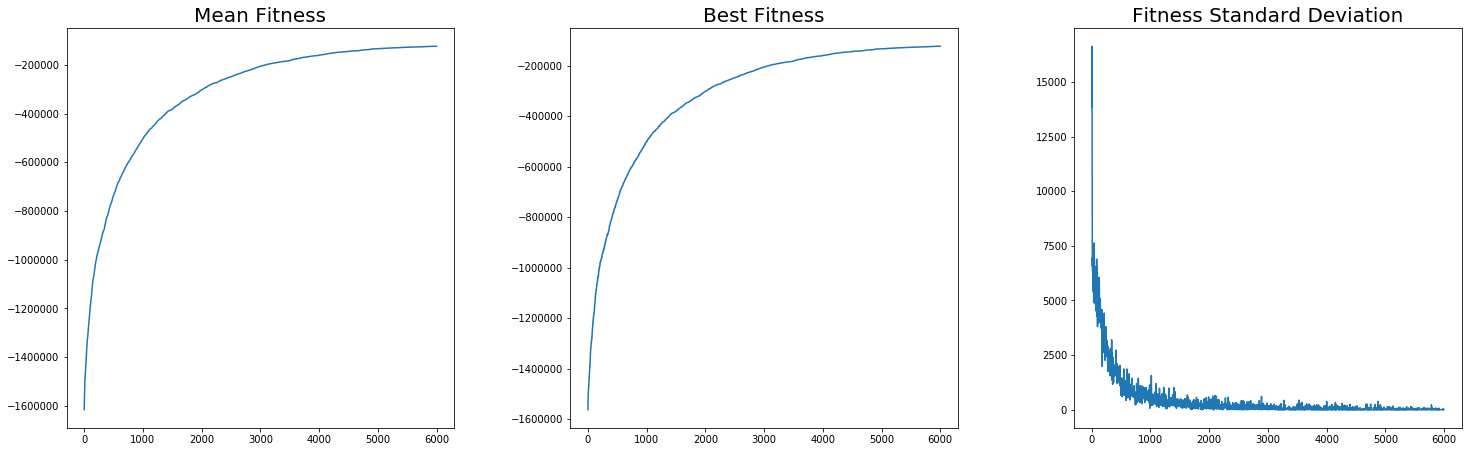

In [22]:
SURVIVOR_METHOD = "mu_plus_lambda"
SELECT_METHOD = "roulette_wheel"
MUTATION_METHOD = "flip"


mu_lambda_tsp = test_tsp()
plot_tsp(mu_lambda_tsp, title="Mu + Lambda Parent and Survivor Selection")

## Animation
Lets plot the best individuals from each generation group to visualize the improvements

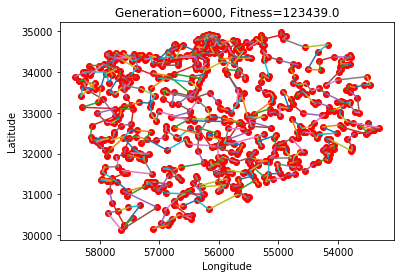

In [23]:
from matplotlib import animation, rc
from IPython.display import HTML

animator = Animation(DATA, mu_lambda_tsp.history["best_individual"], mu_lambda_tsp.history["ani_fitness"], mu_lambda_tsp.history["ani_generation"])
ani = animation.FuncAnimation(animator.fig, animator.animate, init_func=animator.init,
                                       frames=len(animator.history), interval=100, blit=True)
HTML(ani.to_html5_video())

In [12]:
print("hi")

hi
